In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import requests
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
users = pd.read_csv('/opt/ml/data/users_origin.csv')
books = pd.read_csv('/opt/ml/data/books_origin.csv')
ratings = pd.read_csv('/opt/ml/data/train_ratings.csv')

In [5]:
print("users shape: ",users.shape)
print("books shape: ",books.shape)
print("ratings shape: ",ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
ratings shape:  (306795, 3)


[1-2]에서 user 데이터셋의 age 결측치를 채우는데에 사용할 dataframe이다.

In [6]:
user_rating = pd.merge(users,ratings, on='user_id')
user_rating

,user_id,location,age,isbn,rating
0,8,"timmins, ontario, canada",NaN,0002005018,4
1,8,"timmins, ontario, canada",NaN,074322678X,4
2,8,"timmins, ontario, canada",NaN,0887841740,2
3,8,"timmins, ontario, canada",NaN,1552041778,2
4,8,"timmins, ontario, canada",NaN,1567407781,6
...,...,...,...,...,...
306790,278376,"danville, pennsylvania, usa",54.0,0060530103,7
306791,278621,"victoria, delaware, canada",74.0,1550390961,8
306792,278636,"irvington, alabama, usa",NaN,0375507299,2
306793,278659,"vancouver, washington, usa",33.0,0345330293,10


# [1]user

In [7]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [53]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


location 칼럼 세분화

In [54]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

/tmp/ipykernel_72514/3844664685.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거


In [10]:
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins,ontario,canada",NaN,timmins,ontario,canada
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
2,11676,"na,na,na",NaN,NaN,NaN,NaN
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada


In [11]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       3254
location_country     2124
dtype: int64

## [1-1] location

### [1-1-1] 결측치

In [12]:
users.location

0                 timmins,ontario,canada
1                  ottawa,ontario,canada
2                               na,na,na
3                 toronto,ontario,canada
4        victoria,britishcolumbia,canada
                      ...               
68087          danville,pennsylvania,usa
68088           victoria,delaware,canada
68089              irvington,alabama,usa
68090           vancouver,washington,usa
68091          albuquerque,newmexico,usa
Name: location, Length: 68092, dtype: object

In [13]:
sum(users.location.str.count(',')<2) #location에서 city, state, country 중 하나라도 없는 row 확인 (없음)

0

In [14]:
# print("na 1개:",sum(users.location.str.count('na')==1))
# print("na 2개:",sum(users.location.str.count('na')==2))
# print("na 3개:",sum(users.location.str.count('na')==3))

city는 있지만 country는 없는 row 해결

In [55]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

In [56]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

In [17]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city         122
location_state       1132
location_country      271
dtype: int64

## [1-2] age

유저들의 구매기록을 users에 merge한 데이터셋을 이용하여, 이를 바탕으로 age 결측치를 채우고자 한다.

(1) 구매패턴이 비슷한 사람을 참고해서 age를 채우는건? K-Means Clustering 적용

=> 아래 연령별 시각화 + 포브스 기사 보면 알겠지만, 다른 유저들을 참고해서 age 결측치를 채우려고 하면 안 될 듯.

(2) 책을 기준으로 나이를 알 수 있는 다차원 분포 생성? 책 수==차원 수

=>얘도 위랑 비슷.

In [18]:
user_rating.head(10)

,user_id,location,age,isbn,rating
0,8,"timmins, ontario, canada",NaN,0002005018,4
1,8,"timmins, ontario, canada",NaN,074322678X,4
2,8,"timmins, ontario, canada",NaN,0887841740,2
3,8,"timmins, ontario, canada",NaN,1552041778,2
4,8,"timmins, ontario, canada",NaN,1567407781,6
5,8,"timmins, ontario, canada",NaN,1575663937,6
6,8,"timmins, ontario, canada",NaN,1881320189,7
7,11400,"ottawa, ontario, canada",49.0,0786868716,9
8,11400,"ottawa, ontario, canada",49.0,0151008116,6
9,11400,"ottawa, ontario, canada",49.0,0312195516,7


In [19]:
nan_age = user_rating[user_rating['age'].isnull()]

In [20]:
nan_age

,user_id,location,age,isbn,rating
0,8,"timmins, ontario, canada",NaN,0002005018,4
1,8,"timmins, ontario, canada",NaN,074322678X,4
2,8,"timmins, ontario, canada",NaN,0887841740,2
3,8,"timmins, ontario, canada",NaN,1552041778,2
4,8,"timmins, ontario, canada",NaN,1567407781,6
...,...,...,...,...,...
306776,277379,"paderborn, nordrhein-westfalen, germany",NaN,3453156366,5
306778,277479,"mauldin, south carolina, usa",NaN,1588515893,9
306787,278248,"na, manitoba, canada",NaN,080506723X,7
306788,278260,"burlington, massachusetts, usa",NaN,0689821085,2


(3)age가 nan인 유저들의 공통점이 있을까...? (혹시 동화책은 아이들이 직접 구매할 수 없으니 유저가 연령을 따로 선택하지 않았을지도..)

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     67970 non-null  object 
 4   location_state    66960 non-null  object 
 5   location_country  67821 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 3.1+ MB


In [22]:
my_dict=(nan_age['isbn'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['isbn','count'])

In [23]:
count

,isbn,count
0,0316666343,189
1,0312195516,125
2,044023722X,100
3,067976402X,99
4,0385504209,95
...,...,...
51327,1591821789,1
51328,1591825016,1
51329,1853265713,1
51330,0882661078,1


In [24]:
books[books['isbn']==count['isbn'][0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
203,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,NaN,NaN,NaN,images/0316666343.01.THUMBZZZ.jpg


In [25]:
books[books['isbn']==count['isbn'][0]]['img_url']

203    http://images.amazon.com/images/P/0316666343.0...
Name: img_url, dtype: object

In [26]:
books['img_url'][books[books['isbn']==count['isbn'][1]].index[0]]

'http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg'

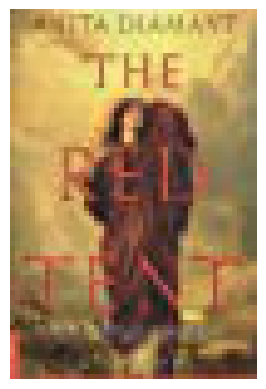

In [27]:
fig= plt.plot(figsize=(3,4))
url = books['img_url'][books[books['isbn']==count['isbn'][1]].index[0]]
img = np.asarray(Image.open(requests.get(url, stream=True, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
plt.axis("off")
plt.imshow(img)

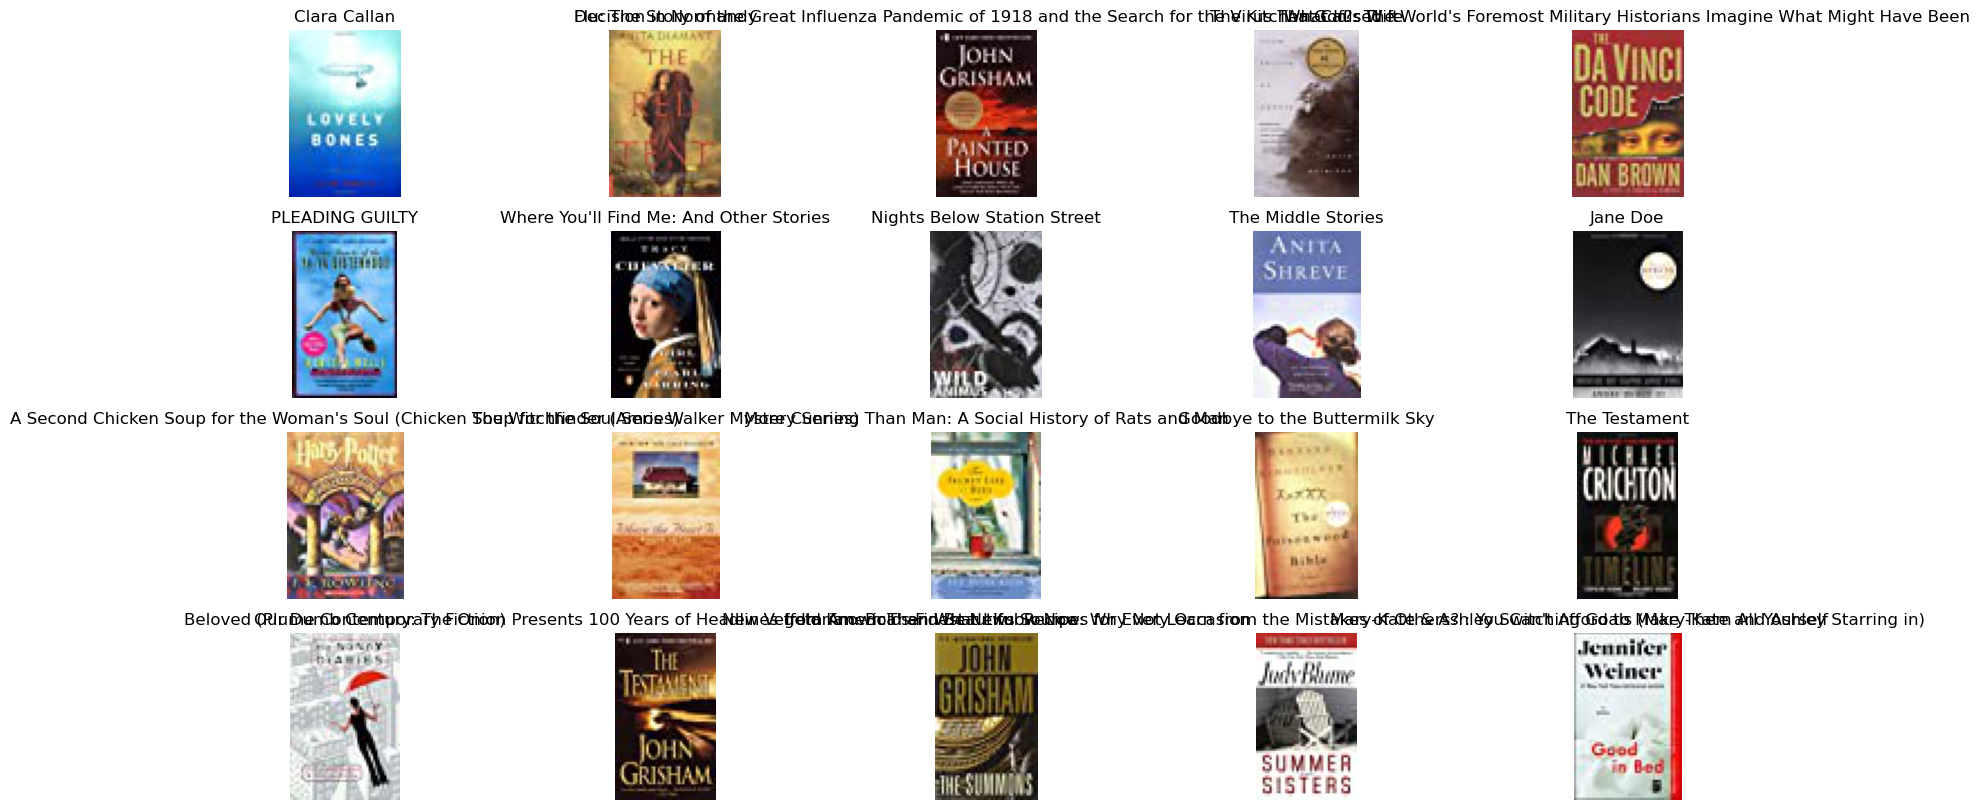

In [28]:
fig, ax = plt.subplots(4, 5, figsize=(20, 10)) 
for i, ax in zip(range(0,20), ax.flatten()):
    # url = books['img_url'][i]
    url = books['img_url'][books[books['isbn']==count['isbn'][i]].index[0]]
    img = np.asarray(Image.open(requests.get(url, stream=True, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
    ax.imshow(img)
    ax.axis("off")
 
    ax.set_title(books['book_title'][i])

fig.show()

음 이렇게 표지만 보면 공통점이 뭔지도 모르겠고, 아동용인지 아닌지도 모르겠다. 

In [57]:
user_rating_cate = user_rating.merge(books,on='isbn')
user_rating_cate.head(10)

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,67544,"toronto, ontario, canada",30.0,0002005018,7,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
5,219008,"halifax, nova scotia, canada",60.0,0002005018,7,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
6,263325,"fredericton, new brunswick, canada",27.0,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
7,8,"timmins, ontario, canada",NaN,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg
8,8,"timmins, ontario, canada",NaN,0887841740,2,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,NaN,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg
9,8,"timmins, ontario, canada",NaN,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Mira Books,http://images.amazon.com/images/P/1552041778.0...,NaN,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg


In [59]:
user_rating_cate.shape

(306795, 14)

In [31]:
ratings.shape #ratings는 구매이력이니까 위의 user_rating_cate과 같아야함. 같음 ㅇㅇ

(306795, 3)

In [60]:
nan_age_cate = user_rating_cate[user_rating_cate['age'].isnull()]
nan_age_cate.head()

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
7,8,"timmins, ontario, canada",NaN,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg


In [19]:
nan_age_cate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92662 entries, 0 to 306792
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              92662 non-null  int64  
 1   location             92662 non-null  object 
 2   age                  0 non-null      float64
 3   isbn                 92662 non-null  object 
 4   rating               92662 non-null  int64  
 5   book_title           92662 non-null  object 
 6   book_author          92662 non-null  object 
 7   year_of_publication  92662 non-null  float64
 8   publisher            92662 non-null  object 
 9   img_url              92662 non-null  object 
 10  language             57454 non-null  object 
 11  category             56948 non-null  object 
 12  summary              57454 non-null  object 
 13  img_path             92662 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 10.6+ MB


In [34]:
books['category'].nunique()

4292

In [35]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
books['category'].unique()

array(["['Actresses']", "['1940-1949']", "['Medical']", "['Fiction']", "['History']", nan, "['Nature']", "['Humor']", "['Cooking']", "['Reference']", "['Juvenile Fiction']", "['Canadian fiction']", "['Health & Fitness']", "['FICTION']", "['Control (Psychology)']", "['Cholistan Desert (Pakistan)']", "['Science']", "['Conduct of life']", "['Horses']", "['Political Science']", "['Brothers']", "['Baggins, Frodo (Fictitious character)']", "['Biography & Autobiography']", "['Business & Economics']", "['Americans']", "['Infanticide']", "['Cabala']", "['Literary Criticism']", "['Self-Help']", "['American fiction']", "['Humorous stories']", "['Diary fiction']", "['Religion']", "['Oglala Indians']", "['England']", "['Social Science']", "['Michigan']", "['Foster mothers']", "['Adolescence']", "['Dune (Imaginary place)']", "['Animals']", "['Great Britain']", "['London (England)']", "['Music']", "['Mars (Planet)']", "['Fairy tales']", '["Children\'s stories"]', "['Jews']", "['Fantasy fiction, Engli

In [61]:
category_high_df = pd.DataFrame(nan_age_cate['category'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df.head(10)

,category,count
0,['Fiction'],34312
1,['Juvenile Fiction'],3271
2,['Biography & Autobiography'],2606
3,['History'],937
4,['Humor'],906
5,['Religion'],709
6,['Social Science'],511
7,['Business & Economics'],510
8,['Juvenile Nonfiction'],484
9,['Family & Relationships'],468


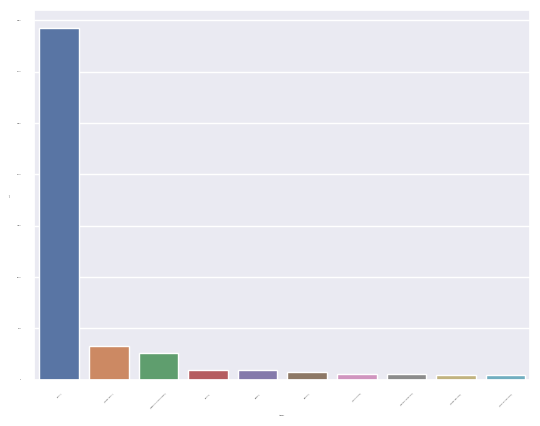

In [62]:
sns.barplot(data= category_high_df.head(10),x='category',y='count')
#sns.set(font_scale= 0)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
plt.bar

In [37]:
nan_age_cate[nan_age_cate['category'].str.contains('child',na=False,case=False)]['category'].unique()

array(["['Abused children']", '["Children\'s stories, American"]', '["Children\'s stories"]', "['Child rearing']", '["Children\'s literature"]', "['Picture books for children']", "['Missing children']", "['Adult child abuse victims']", "['Childbirth']", '["Children\'s writings, American"]', "['Adopted children']", "['Child care']", "['Children']", "['Child psychologists']", '["Children\'s literature, Swedish"]', "['Etiquette for children and teenagers']", '["Children\'s stories."]', "['Child abuse']", '["Children\'s stories, English"]', "['Child development']", "['Children and war']", "['Children of celebrities']", "['Child psychology']", '["Children\'s poetry, American"]', "['Children of Holocaust survivors']", '["Children\'s poetry, American."]', '["Children\'s stories, American."]', "['Child labor']", '["Children\'s audiobooks"]', "['Childlessness']", "['Child psychotherapy']", "['Indian children']", "['Children and adults']", "['Boxcar children (Fictitious characters)']", "['Mental

In [38]:
nan_age_cate[nan_age_cate['category'].str.contains('Children of alcoholics',na=False,case=False)]
#위에 훑다가 진짜 children 전용이 맞나 확인해봤는데 아니엇숨

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
199658,31846,"phoenix, , usa",NaN,0394757572,8,Ellen Foster (Vintage contemporaries),Kaye Gibbons,1988.0,Vintage Books,http://images.amazon.com/images/P/0394757572.0...,en,['Children of alcoholics'],One of the most talked-about and endearing fir...,images/0394757572.01.THUMBZZZ.jpg


In [39]:
nan_age_cate[nan_age_cate['category'].str.contains('Adopted children',na=False,case=False)]

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
46283,11676,"n/a, n/a, n/a",NaN,0671021974,8,Orphans 1: Butterfly (Orphans),Virginia Andrews,1999.0,Simon & Schuster (Trade Division),http://images.amazon.com/images/P/0671021974.0...,en,['Adopted children'],Butterfly is the first in the Orphans series f...,images/0671021974.01.THUMBZZZ.jpg
188076,223814,"london, england, united kingdom",NaN,0340850809,6,Saffy's Angel,Hilary McKay,2002.0,Hodder Children's Books,http://images.amazon.com/images/P/0340850809.0...,en,['Adopted children'],"After learning that she was adopted, thirteen-...",images/0340850809.01.THUMBZZZ.jpg
231512,1248,"dixon, california, usa",NaN,0440455332,10,Me and My Little Brain,JOHN FITZGERALD,1972.0,Yearling,http://images.amazon.com/images/P/0440455332.0...,en,['Adopted children'],When the Great Brain leaves Adenville to atten...,images/0440455332.01.THUMBZZZ.jpg


In [40]:
user_rating[user_rating['user_id']==11676]
#엥 이게 말이 되나
#user_rating 데이터셋이 잘못 merge됐나?

,user_id,location,age,isbn,rating
19,11676,"n/a, n/a, n/a",NaN,0399135782,8
20,11676,"n/a, n/a, n/a",NaN,0440234743,8
21,11676,"n/a, n/a, n/a",NaN,1841721522,10
22,11676,"n/a, n/a, n/a",NaN,0971880107,6
23,11676,"n/a, n/a, n/a",NaN,0345417623,9
...,...,...,...,...,...
5534,11676,"n/a, n/a, n/a",NaN,9812327975,7
5535,11676,"n/a, n/a, n/a",NaN,9879397274,7
5536,11676,"n/a, n/a, n/a",NaN,987960170X,3
5537,11676,"n/a, n/a, n/a",NaN,9974643058,7


In [41]:
print('users: ',users.shape)
print('ratings: ',ratings.shape)
print('merge users & ratings by ratings: ',user_rating.shape)
#아닌데... rating 기준으로 잘 됐삼.

users:  (68092, 6)
ratings:  (306795, 3)
merge users & ratings by ratings:  (306795, 5)


In [42]:
user_rating

,user_id,location,age,isbn,rating
0,8,"timmins, ontario, canada",NaN,0002005018,4
1,8,"timmins, ontario, canada",NaN,074322678X,4
2,8,"timmins, ontario, canada",NaN,0887841740,2
3,8,"timmins, ontario, canada",NaN,1552041778,2
4,8,"timmins, ontario, canada",NaN,1567407781,6
...,...,...,...,...,...
306790,278376,"danville, pennsylvania, usa",54.0,0060530103,7
306791,278621,"victoria, delaware, canada",74.0,1550390961,8
306792,278636,"irvington, alabama, usa",NaN,0375507299,2
306793,278659,"vancouver, washington, usa",33.0,0345330293,10


In [43]:
all_merge = pd.merge(user_rating,books,on='isbn')
all_merge[all_merge.location.str.count('n/a')==3]
#엥 위에서 user_id 11676이 5520개였는데, 여기는 5525개임. 아마 77036아 나머지 5개인 듯.

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
14,11676,"n/a, n/a, n/a",NaN,0786868716,8,The Five People You Meet in Heaven,Mitch Albom,2003.0,Hyperion,http://images.amazon.com/images/P/0786868716.0...,en,['Fiction'],"With a timeless tale, appealing to all, this i...",images/0786868716.01.THUMBZZZ.jpg
207,11676,"n/a, n/a, n/a",NaN,0151008116,5,Life of Pi,Yann Martel,2002.0,Harcourt,http://images.amazon.com/images/P/0151008116.0...,en,['Fiction'],"After the sinking of a cargo ship, a solitary ...",images/0151008116.01.THUMBZZZ.jpg
282,11676,"n/a, n/a, n/a",NaN,0312195516,10,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,http://images.amazon.com/images/P/0312195516.0...,en,['Fiction'],"Told in Dinah&#39;s voice, this novel reveals ...",images/0312195516.01.THUMBZZZ.jpg
589,11676,"n/a, n/a, n/a",NaN,0316789089,8,The Pilot's Wife : A Novel Tag: Author of the ...,Anita Shreve,1999.0,"Little, Brown",http://images.amazon.com/images/P/0316789089.0...,NaN,NaN,NaN,images/0316789089.01.THUMBZZZ.jpg
641,11676,"n/a, n/a, n/a",NaN,0440222656,1,The Horse Whisperer,Nicholas Evans,1996.0,Dell,http://images.amazon.com/images/P/0440222656.0...,en,['Fiction'],After her teenage daughter and the girl&#39;s ...,images/0440222656.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51242,11676,"n/a, n/a, n/a",NaN,B0000DYXID,10,A Kid's Guide To How to Save the Planet,Billy Goodman,1994.0,"iBooks, Inc.",http://images.amazon.com/images/P/B0000DYXID.0...,NaN,NaN,NaN,images/B0000DYXID.01.THUMBZZZ.jpg
112130,70063,"n/a, n/a, n/a",NaN,0688171478,7,Friendship Cake: A Novel,Lynne Hinton,2000.0,HarperSanFrancisco,http://images.amazon.com/images/P/0688171478.0...,en,['Fiction'],Here are timeless truths--about the complexiti...,images/0688171478.01.THUMBZZZ.jpg
178761,70063,"n/a, n/a, n/a",NaN,1862300372,8,Mad Elaine,Helen Stevenson,1998.0,Anchor (UK),http://images.amazon.com/images/P/1862300372.0...,en,['Families'],"On the face of it, Madelaine is a dumpy, dull ...",images/1862300372.01.THUMBZZZ.jpg
238868,70063,"n/a, n/a, n/a",NaN,0725107251,8,From strength to strength: An autobiography,Sara Henderson,1993.0,Pan MacMillan Publishers Australia,http://images.amazon.com/images/P/0725107251.0...,NaN,NaN,NaN,images/0725107251.01.THUMBZZZ.jpg


In [44]:
all_merge[all_merge['user_id']==70063]
#맞쥐?

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
36637,70063,"n/a, n/a, n/a",NaN,0375756981,8,The Vagina Monologues: The V-Day Edition,Eve Ensler,2000.0,Villard Books,http://images.amazon.com/images/P/0375756981.0...,en,['Performing Arts'],A poignant and hilarious tour of the last fron...,images/0375756981.01.THUMBZZZ.jpg
112130,70063,"n/a, n/a, n/a",NaN,0688171478,7,Friendship Cake: A Novel,Lynne Hinton,2000.0,HarperSanFrancisco,http://images.amazon.com/images/P/0688171478.0...,en,['Fiction'],Here are timeless truths--about the complexiti...,images/0688171478.01.THUMBZZZ.jpg
178761,70063,"n/a, n/a, n/a",NaN,1862300372,8,Mad Elaine,Helen Stevenson,1998.0,Anchor (UK),http://images.amazon.com/images/P/1862300372.0...,en,['Families'],"On the face of it, Madelaine is a dumpy, dull ...",images/1862300372.01.THUMBZZZ.jpg
238868,70063,"n/a, n/a, n/a",NaN,0725107251,8,From strength to strength: An autobiography,Sara Henderson,1993.0,Pan MacMillan Publishers Australia,http://images.amazon.com/images/P/0725107251.0...,NaN,NaN,NaN,images/0725107251.01.THUMBZZZ.jpg
250117,70063,"n/a, n/a, n/a",NaN,0285631144,10,Dogwise: The Natural Way to Train Your Dog,John Fisher,1996.0,Souvenir Press,http://images.amazon.com/images/P/0285631144.0...,NaN,NaN,NaN,images/0285631144.01.THUMBZZZ.jpg


일단 위 두 user는 새로운 나이 범주를 부여해야할 것 같다. 아예 지우는 건 아닌 것 같다.

위에 두 user말고도 age가 nan인 user 중에 대량으로 책을 구매한 사람이 있을까

In [45]:
nan_age_cate

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
7,8,"timmins, ontario, canada",NaN,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306776,277379,"paderborn, nordrhein-westfalen, germany",NaN,3453156366,5,Idoru.,William Gibson,1999.0,Heyne,http://images.amazon.com/images/P/3453156366.0...,NaN,NaN,NaN,images/3453156366.01.THUMBZZZ.jpg
306778,277479,"mauldin, south carolina, usa",NaN,1588515893,9,Sisters Forever,Sharon D. Martin,2001.0,PublishAmerica,http://images.amazon.com/images/P/1588515893.0...,NaN,NaN,NaN,images/1588515893.01.THUMBZZZ.jpg
306787,278248,"na, manitoba, canada",NaN,080506723X,7,Desert Burial: A Novel,Brian Littlefair,2002.0,Henry Holt & Company,http://images.amazon.com/images/P/080506723X.0...,en,['Fiction'],"Nuclear waste, Africa, and the new world order...",images/080506723X.01.THUMBZZZ.jpg
306788,278260,"burlington, massachusetts, usa",NaN,0689821085,2,BUYING TIME (On the Road),Stephanie Doyon,1999.0,Simon Pulse,http://images.amazon.com/images/P/0689821085.0...,en,['Juvenile Fiction'],"Miranda, tired of always being the good girl, ...",images/0689821085.01.THUMBZZZ.jpg


다시 생각해봤을 때,이 사이트는 최초 회원가입 시 주소 입력은 필수여도 나이는 선택인 것 같다. 나이 체크를 잘 안 할만한 연령대는 뭘까,,, 

음 근데 두번째로 많은 category가 Juvenile Fiction이네. 10대로 처리해도 되지 않을까? age 분포를 확인해서 10대가 압도적으로 적으면 10대로 메꿔도 되지 않을까?하하하하하

아니 일리가 있는게, 보통 온라인 서점은 온라인으로 결제해야하는데 우리나라도 계좌이체나 카드 결제를 10대가 못 하지 않나? 아아닌감

In [63]:
drop_age_nan = users.dropna(subset=['age'], how='any', axis=0)
drop_age_nan

,user_id,location,age,location_city,location_state,location_country
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada
5,96054,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
8,177458,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
...,...,...,...,...,...,...
68086,278330,"livonia,newyork,usa",46.0,livonia,michigan,usa
68087,278376,"danville,pennsylvania,usa",54.0,danville,california,usa
68088,278621,"victoria,delaware,canada",74.0,victoria,delaware,canada
68090,278659,"vancouver,washington,usa",33.0,vancouver,britishcolumbia,canada


In [13]:
drop_age_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40259 entries, 1 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40259 non-null  int64  
 1   location  40259 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [14]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6
    

drop_age_nan = drop_age_nan['age'].apply(age_map)


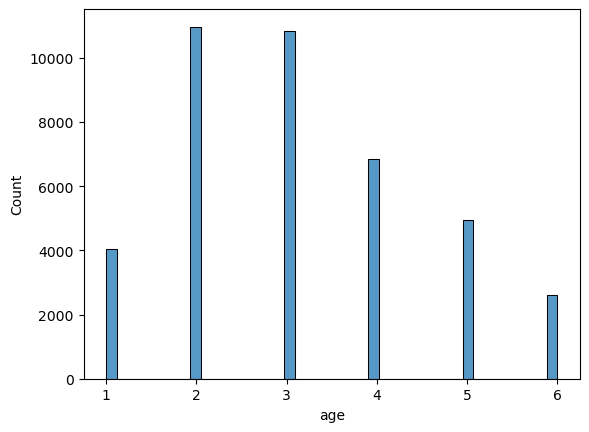

In [15]:
sns.histplot(drop_age_nan)
plt.show()

음 애매하다... 아놩 압도적으로 적진 않은데,,, 내 기억에 전체 데이터에서 미국이 ''압도적''으로 많았던 것 같은데 ㅎㅎ 확인해보고 맞으면 미국 연령대별 독서량 조사해보고, 독서량이 10대가 적어도 60대보다는 많다고 하면 그냥 juvenile은 10대로 모두 채울 것!

In [64]:
nan_age_user = users.dropna(subset=['age'],how='any',axis=0) #위의 nan_age랑 다르다. nan_age는 rating 데이터셋과 merge해서 유저가 중복돼서 나온다. 이건 user 데이터셋만 이용한 것.
nan_age_user

,user_id,location,age,location_city,location_state,location_country
1,11400,"ottawa,ontario,canada",49.0,ottawa,ontario,canada
3,67544,"toronto,ontario,canada",30.0,toronto,ontario,canada
4,85526,"victoria,britishcolumbia,canada",36.0,victoria,britishcolumbia,canada
5,96054,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
8,177458,"ottawa,ontario,canada",29.0,ottawa,ontario,canada
...,...,...,...,...,...,...
68086,278330,"livonia,newyork,usa",46.0,livonia,michigan,usa
68087,278376,"danville,pennsylvania,usa",54.0,danville,california,usa
68088,278621,"victoria,delaware,canada",74.0,victoria,delaware,canada
68090,278659,"vancouver,washington,usa",33.0,vancouver,britishcolumbia,canada


In [42]:
print('user shape: ',users.shape)
print('except nan age users shape:', nan_age_user.shape)

user shape:  (68092, 3)
except nan age users shape: (40259, 3)


In [43]:
nan_age_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40259 entries, 1 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40259 non-null  int64  
 1   location  40259 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


국가 분포(location country)

엥 top 7정도만 잘라서 봐야겠다

In [65]:
my_dict=(nan_age_user['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['country','count'])
count

,country,count
0,usa,24990
1,canada,3386
2,germany,2498
3,unitedkingdom,2190
4,spain,1571
...,...,...
196,northyorkshire,1
197,mongolia,1
198,bahamas,1
199,bahrain,1


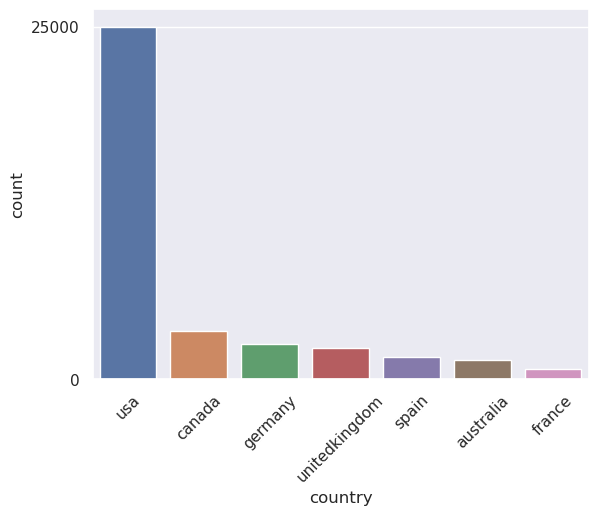

In [81]:
top7 = count.head(7)
sns.barplot(data = top7, x = 'country', y='count')
sns.set(font_scale = 10)
plt.xticks(rotation=45)
plt.show()

In [72]:
plt.bar(x=top7['country'],y=top7['count'])

TypeError: bar() missing 1 required positional argument: 'height'

엥 볼 필요도 없을 듯. 걍 usa가 압도적,,,

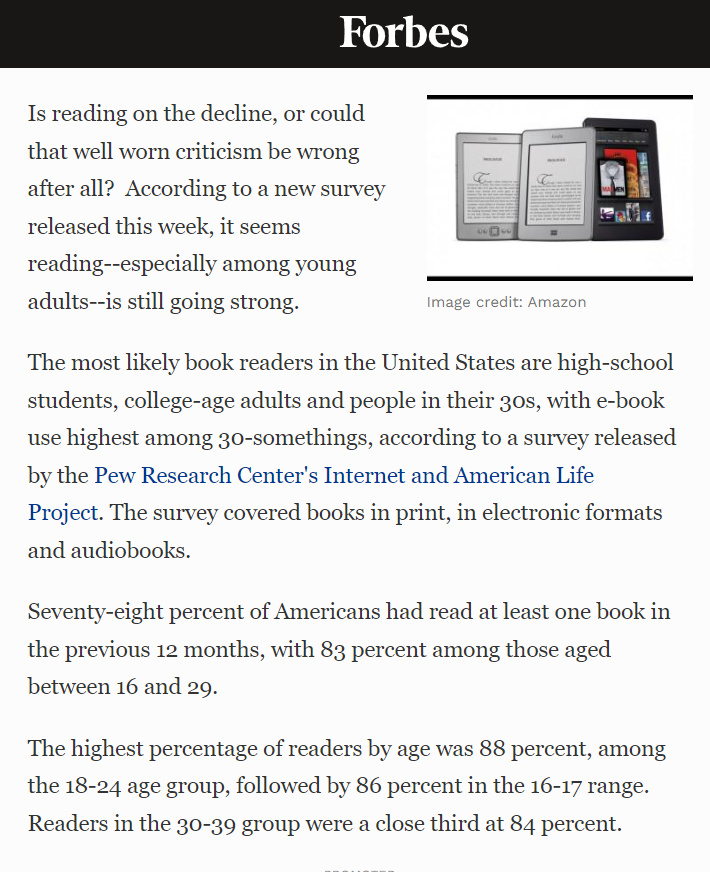

https://www.forbes.com/sites/daviddisalvo/2012/10/23/who-reads-the-most-in-the-us-the-answer-might-surprise-you/?sh=5efa86e928b2

융 포브스 선정 10-20대 압도적이라는^^ => 계획대로 Juvenile은 10대로 채우기(사실 fiction도 다 10대로 채워도 괜찮을 듯)

아 고민이네,,ㅠㅠㅠㅠㅠㅠ 또 나머지 category들은 어카누,,, 걍 버리는게 답인가,,,

In [55]:
# 그래도 혹시 모르니까 상관분석이랑 딴 거 해보고 바꿀게,,,

(4) user와 book을 merge한 데이터셋을 가지고 상관관계 분석?

In [56]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [57]:
# age랑 연속형 변수끼리 피어슨 상관계수 구해보고, age랑 나머지 범주형 변수들끼리 t-test든 뭐든 해보기
# 상관성 높게 나온 변수 하나?를 기준으로 분류해서 참고하기
# ex) language이다. language별 나이 최빈값 or 평균으로 채우기

user와 book, rating 모두 merge(on='isbn')

In [58]:
user_rating_cate.head(10)

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,8,"timmins, ontario, canada",NaN,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,67544,"toronto, ontario, canada",30.0,0002005018,7,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
2,123629,"kingston, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
3,200273,"comber, ontario, canada",NaN,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
4,210926,"guelph, ontario, canada",NaN,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
5,219008,"halifax, nova scotia, canada",60.0,0002005018,7,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
6,263325,"fredericton, new brunswick, canada",27.0,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
7,8,"timmins, ontario, canada",NaN,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner,http://images.amazon.com/images/P/074322678X.0...,en,['Fiction'],"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg
8,8,"timmins, ontario, canada",NaN,0887841740,2,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,NaN,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg
9,8,"timmins, ontario, canada",NaN,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Mira Books,http://images.amazon.com/images/P/1552041778.0...,NaN,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg


In [59]:
all_merge = user_rating_cate.copy()

/tmp/ipykernel_30913/528954918.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(all_merge.corr(),annot=True)


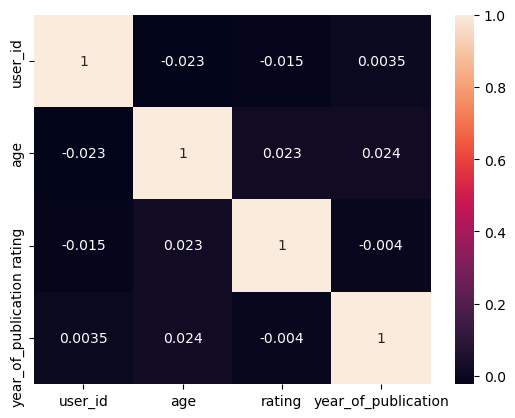

In [60]:
sns.heatmap(all_merge.corr(),annot=True)
plt.show()
#처참한 결과... 우선 age랑 rating 선형관계 없는 것 확인.

In [61]:
books['language'].unique()

array(['en', nan, 'de', 'fr', 'es', 'ca', 'it', 'da', 'nl', 'pt', 'ro', 'no', 'ms', 'la', 'ru', 'el', 'zh-CN', 'th', 'gl', 'ja', 'fa', 'eo', 'gd', 'ga', 'vi', 'zh-TW', 'ko'], dtype=object)

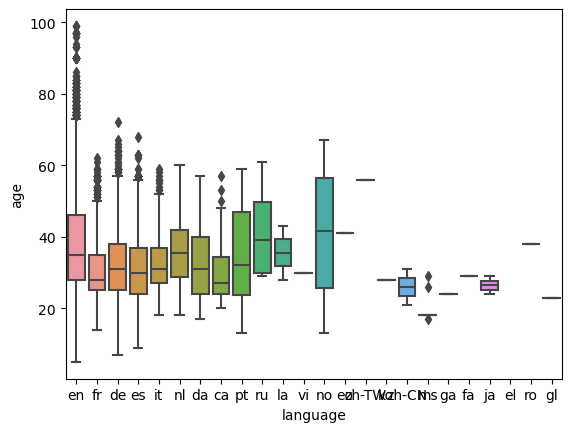

In [62]:
sns.boxplot(all_merge, x='language', y='age')
plt.show()

box가 약 10살 단위보다 같거나 작은 경우는 그 평균 나이로 대체해도 될 듯.

In [63]:
category_high_df #age가 nan인 사용자들이 구매한 책의 category

,category,count
0,['Fiction'],34312
1,['Juvenile Fiction'],3271
2,['Biography & Autobiography'],2606
3,['History'],937
4,['Humor'],906
...,...,...
1930,['Parenting'],1
1931,['Country homes'],1
1932,['Loneliness'],1
1933,['Cross-dressing'],1


In [64]:
age_nan_cate = category_high_df.copy()
age_nan_cate = age_nan_cate[age_nan_cate['count']>5]
age_nan_cate

,category,count
0,['Fiction'],34312
1,['Juvenile Fiction'],3271
2,['Biography & Autobiography'],2606
3,['History'],937
4,['Humor'],906
...,...,...
260,['Actresses'],6
261,['Courtship'],6
262,['Espionage'],6
263,"['Horror tales, American']",6


In [65]:
age_nan_cate2 = age_nan_cate.copy()
age_nan_cate2 = age_nan_cate2[age_nan_cate2['count']>200]
age_nan_cate2
#sns.scatterplot(age_nan_cate2,x=age_nan_cate.index,y='count')

,category,count
0,['Fiction'],34312
1,['Juvenile Fiction'],3271
2,['Biography & Autobiography'],2606
3,['History'],937
4,['Humor'],906
5,['Religion'],709
6,['Social Science'],511
7,['Business & Economics'],510
8,['Juvenile Nonfiction'],484
9,['Family & Relationships'],468


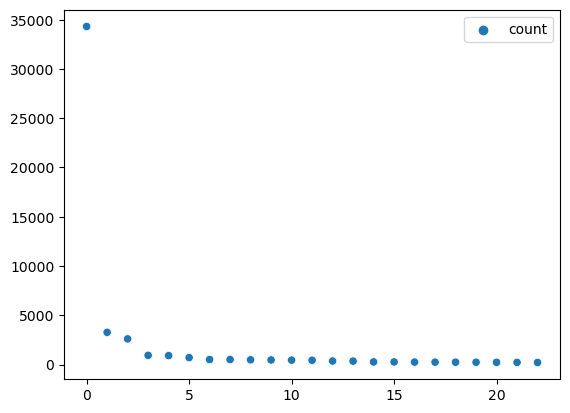

In [66]:
sns.scatterplot(age_nan_cate2)
plt.show()

아 이거 산으로 간다. 일단 범주형-수치형 상관관계 분석이 힘들 듯. 범주가 너무 많은데 어디부터 잘라내서 써야할지 모르겠음.

In [67]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


정리:

    books 데이터셋 => 성현님 전처리 코드 긁어와서 그대로

    users 데이터셋 => category에 'Junevile'들어간 책 구매한 유저 10대로 처리. 어떻게? Junevile 최빈값 or 평균을 대체값으로 넣으면 될 듯

    나머지 age 결측치들 => country, language랑 category가 가장 연관있어보임.

        (0)location과 age 모두 nan인 user 2명있음. 얘네는 nan값 자체를 age로 설정해야할 듯.(예외로 생각해야할 듯)

        (1)language: 범주별 boxplot 그려서 10살 범위보다 박스가 작은 것만 평균으로 대체하기

        (2)category: fiction이 관건임. 나머지는 100개 이상인 category들만 똑같이 boxplot 그려서 같은 방법으로. 100개 이하는 그냥 nan값으로 나둬도 괜찮을 듯. fiction은 일단 보류

        (3)country: 어카누

### 긴급긴급!!!
모델에 따라서 안 쓰이는 변수가 있을 수도 있다?!?!?!?!
fiction 대소문자 다른거 잇슴
작가 띄어쓰기가 다른거 있음

추가 가설

1. category도 유행을 따르지 않을까. publication year는 결측치가 하나도 없음. 시각화 해보고 상관관계 분석(성현님 방법 먼저 적용 후 나머지 결측값)

2. category를 조금 축소. bear,dog는 animal 카테고리로. 그 다음 다시 성현님 방법

3. book author에서 . 등 특수문자들 아예 지울지, or 다른 처리 방법(우선은 지움)